# Foraging toolkit demo - follower birds

## Outline
* [Introduction](##introduction)
* [Simulation](#simulation)
* [Derived quantities](#derived-quantities)
* [Inference](#inference)

## Introduction

In this notebook we use the foraging toolkit to simulate agents that move toward other agents. 

The users are advised to familiarize themselves first with the `random_foragers.ipynb` demo, which contains a detailed explanation of the various commands and methods used in this notebook.

The follower behavior is in contrast to _hungry agents_, who care only about food location (see the `hungry_foragers.ipynb` demo notebook).

The main reference is [1], in particular Fig.2.

---

[1] R. Urbaniak, M. Xie, and E. Mackevicius, “Linking cognitive strategy, neural mechanism, and movement statistics in group foraging behaviors,” Sci Rep, vol. 14, no. 1, p. 21770, Sep. 2024, [doi: 10.1038/s41598-024-71931-0.](https://www.nature.com/articles/s41598-024-71931-0)

In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import random
import time

import dill
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio

pio.renderers.default = "notebook"

import collab.foraging.toolkit as ft
from collab.foraging import random_hungry_followers as rhf

logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub,
# to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

notebook_starts = time.time()
#test

## Simulation


**Simulation of follower foragers**

- **Initialization**
    - Initialize the grid with a specified grid size
    - Randomly place `num_rewards` rewards
    - Normalize the probabilities for forager step size
- **Forward Simulation**
    - For each frame:
        - Update visibility for foragers
        - Compute proximity scores for all foragers, with local maxima at other foragers' locations and exponential decay.
        - For each forager:
            - Weight proximity scores with the forager's visibility scores
            - Sort accessible points by the above weighted score
            - Move forager to a randomly chosen position from among top 10 ranking points above

- **Update Rewards**
    - At each frame, remove a reward if a forager is next to it, starting from that frame onward.


2024-10-30 07:44:00,394 - Generating frame 10/50 
2024-10-30 07:44:01,178 - Generating frame 20/50 
2024-10-30 07:44:01,830 - Generating frame 30/50 
2024-10-30 07:44:02,462 - Generating frame 40/50 


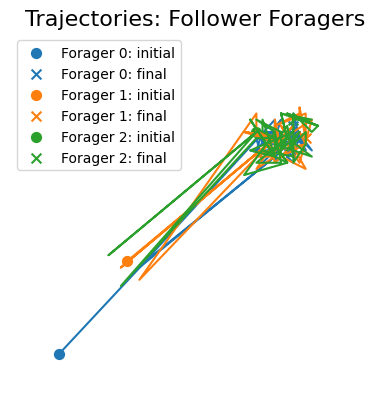

In [2]:
random.seed(23)
np.random.seed(23)

# create a new empty simulation (a starting point for the actual simulation)
grid_size = 60
follower_sim = rhf.Foragers(
    grid_size=grid_size,
    num_foragers=3,
    num_frames=num_frames,
    num_rewards=30,
    grab_range=3,
)

# run the simulation: this places the rewards on the grid
follower_sim()

# add the followers to the simulation and run simulation forward
follower_sim = rhf.add_follower_foragers(
    follower_sim,
    num_follower_foragers=3,
    visibility_range=45,
    getting_worse=0.5,
    optimal=3,
    proximity_decay=2,
    initial_positions=np.array([[10, 10], [20, 20], [40, 40]]),
)

# display(follower_sim.foragersDF)
ax = ft.plot_trajectories(follower_sim.foragersDF, "Follower Foragers")
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
plt.show()

Unsurprisingly, all the foragers tend to stay close to each other and do not explore the environment.

In [3]:
ft.animate_foragers(
    follower_sim, width=600, height=400, plot_rewards=True, point_size=6, autosize=True
)

## Derived quantities

In [4]:
# We'll use `proximity`, `food` and `access` predictors

local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

predictor_kwargs = {
    "proximity": {
        "interaction_length": follower_sim.grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": 1.5,
        "optimal_distance": 4,
        "proximity_decay": 1,
    },
    "food": {
        "decay_factor": 0.5,
    },
    "access": {
        "decay_factor": 0.2,
    },
}

score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

derivedDF_hungry = ft.derive_predictors_and_scores(
    follower_sim,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

# display(derivedDF_hungry)

2024-10-30 07:44:06,025 - proximity completed in 0.79 seconds.
2024-10-30 07:44:08,634 - food completed in 2.61 seconds.
2024-10-30 07:44:08,929 - access completed in 0.29 seconds.
2024-10-30 07:44:09,110 - nextStep_linear completed in 0.18 seconds.
2024-10-30 07:44:09,284 - nextStep_sublinear completed in 0.17 seconds.
/home/rafal/s78projects/collab-creatures/collab/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 951/47528 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      



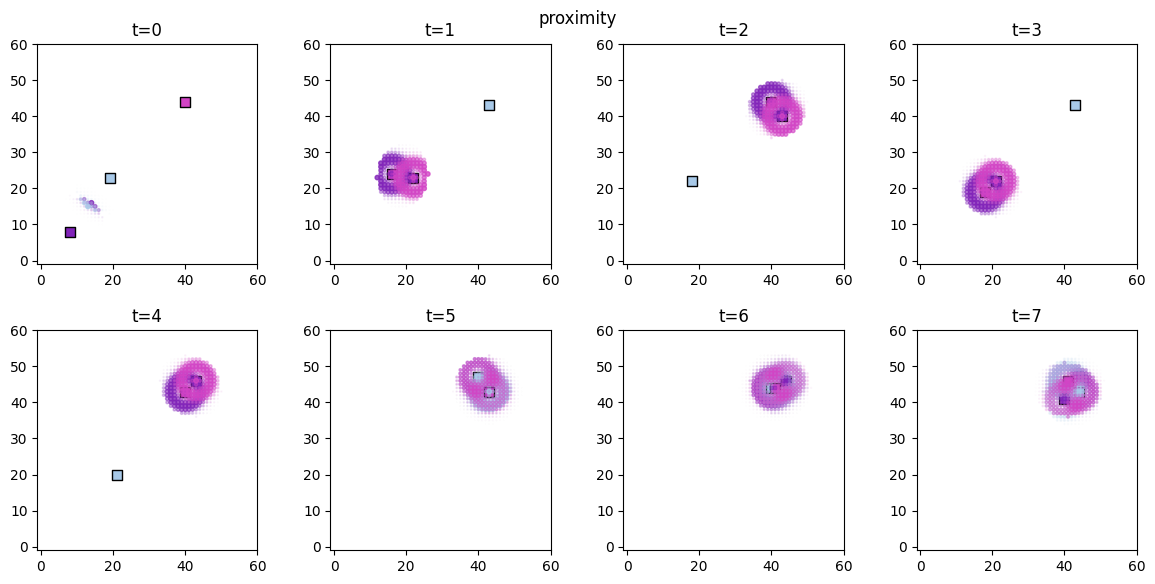

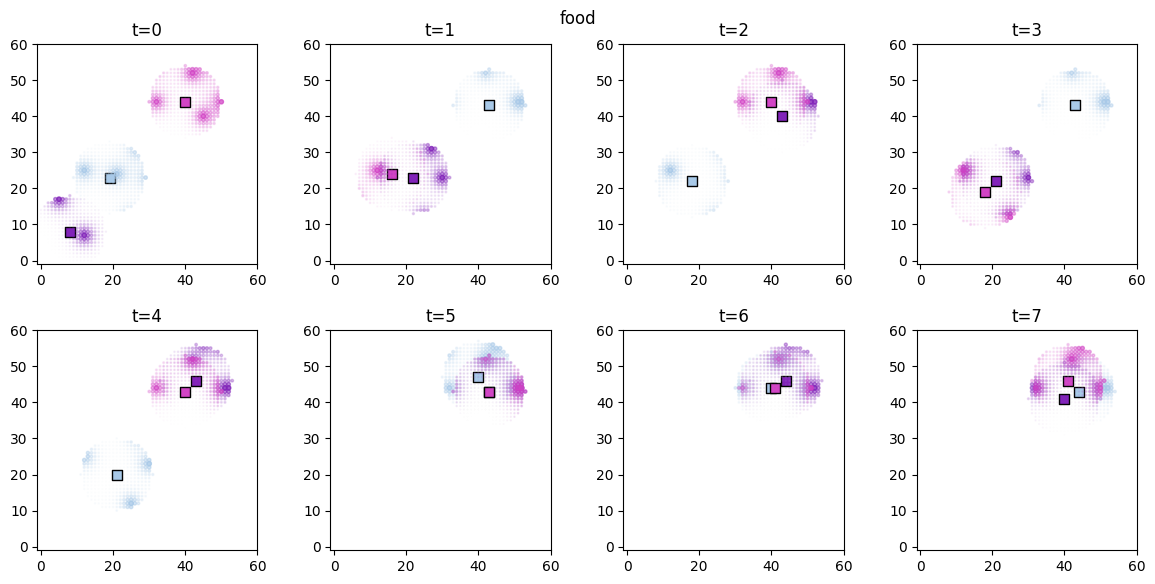

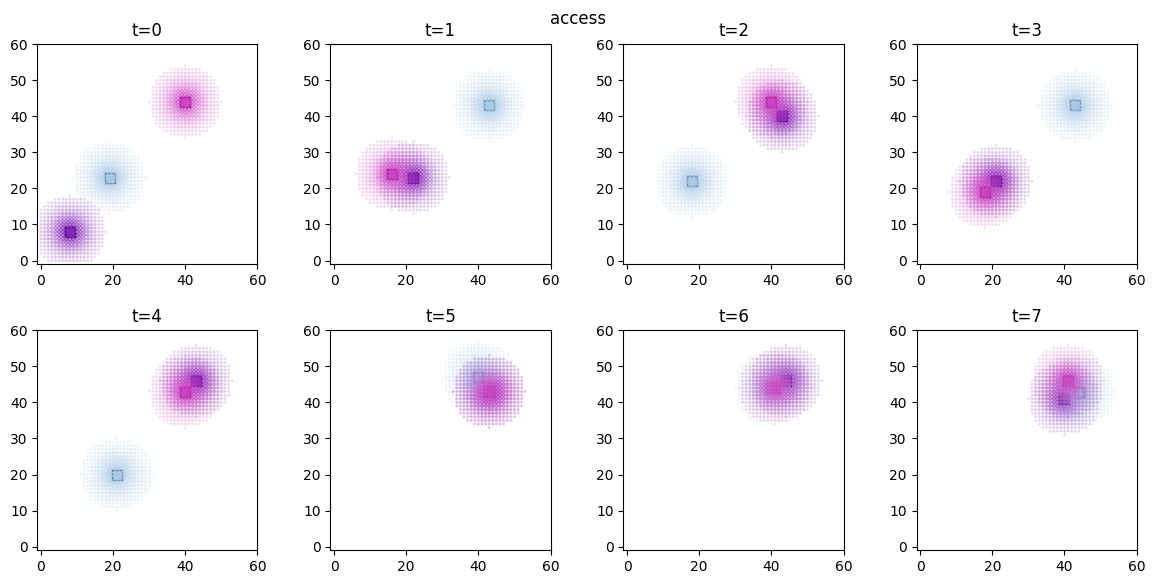

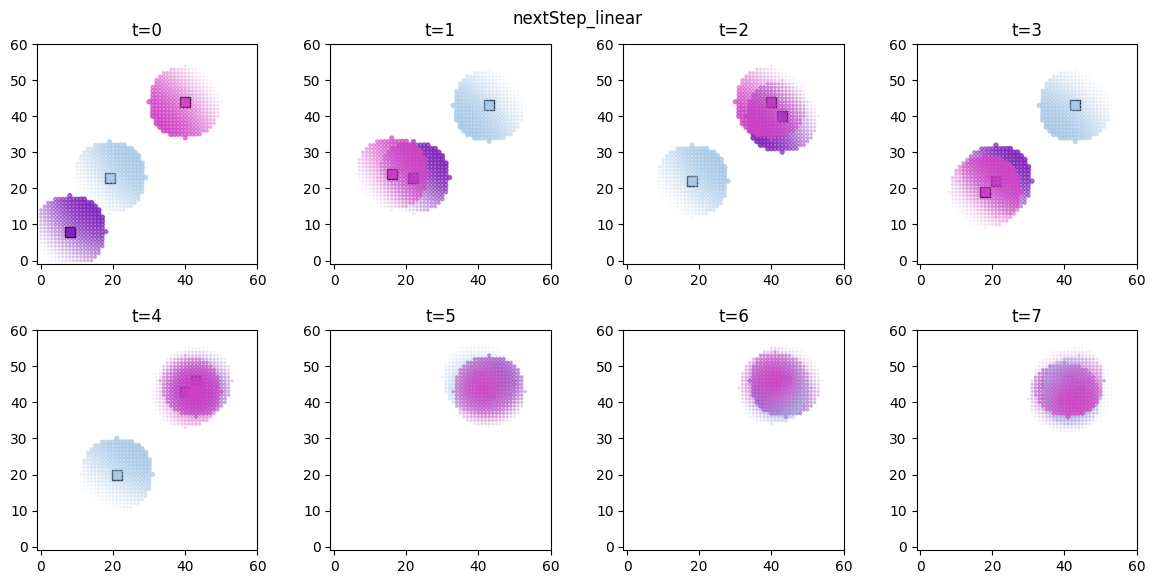

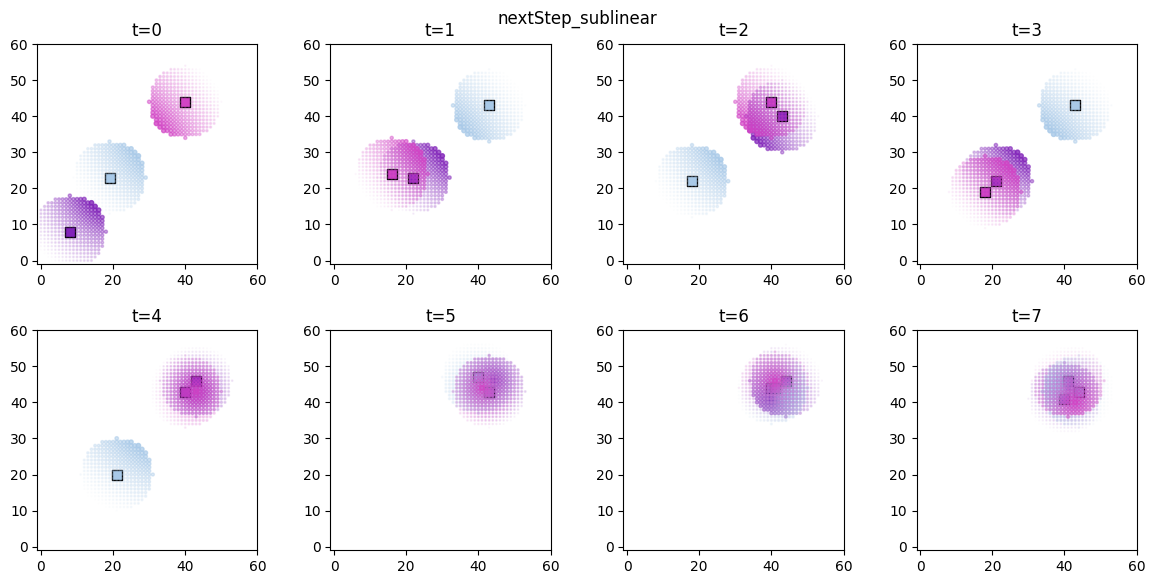

In [5]:
# visualize the spatial distributions of the derived quantities for each forager

for derived_quantity_name in follower_sim.derived_quantities.keys():
    ft.plot_predictor(
        follower_sim.foragers,
        follower_sim.derived_quantities[derived_quantity_name],
        predictor_name=derived_quantity_name,
        time=range(min(8, num_frames)),
        grid_size=grid_size,
        size_multiplier=10,
        random_state=99,
        forager_position_indices=[0, 1, 2],
        forager_predictor_indices=[0, 1, 2],
    )
    plt.suptitle(derived_quantity_name)
    plt.show()

## Inference

2024-10-30 07:44:14,860 - Sample size: 46577
2024-10-30 07:44:14,861 - Starting SVI inference with 1500 iterations.


[iteration 0001] loss: 173423.7031
[iteration 0200] loss: 114659.1953
[iteration 0400] loss: 114057.9609
[iteration 0600] loss: 113852.7109
[iteration 0800] loss: 114462.4297
[iteration 1000] loss: 113906.8047
[iteration 1200] loss: 113913.0156
[iteration 1400] loss: 113834.5938


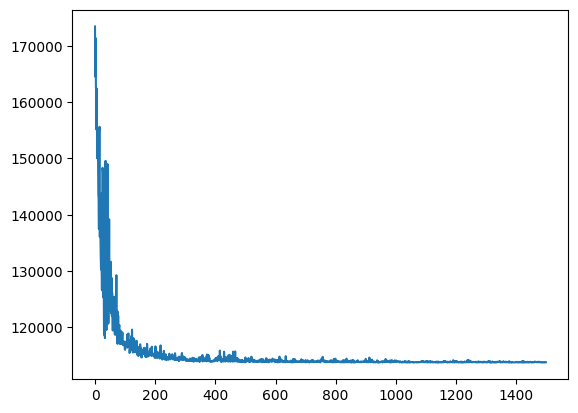

2024-10-30 07:44:38,500 - SVI inference completed in 23.64 seconds.


Coefficient marginals:
Site: weight_continuous_proximity_scaled_nextStep_sublinear
       mean       std        5%       25%       50%       75%       95%
0  0.443248  0.016135  0.416449  0.432873  0.443128  0.453821  0.470375 

Site: weight_continuous_food_scaled_nextStep_sublinear
       mean     std        5%       25%       50%      75%       95%
0 -0.075822  0.0137 -0.098856 -0.085156 -0.076391 -0.06672 -0.053665 

Site: weight_continuous_access_scaled_nextStep_sublinear
       mean       std        5%       25%       50%       75%       95%
0  0.321284  0.017224  0.293994  0.309326  0.321115  0.333247  0.349644 



In [6]:
# prepare the training data

predictors = ["proximity_scaled", "food_scaled", "access_scaled"]
outcome_vars = ["nextStep_sublinear"]


predictor_tensors_follower, outcome_tensor_follower = ft.prep_data_for_inference(
    follower_sim, predictors, outcome_vars
)

# construct Pyro model
model_sigmavar_follower = ft.HeteroskedasticLinear(
    predictor_tensors_follower, outcome_tensor_follower
)

# runs SVI to approximate the posterior and samples from it
results_follower = ft.get_samples(
    model=model_sigmavar_follower,
    predictors=predictor_tensors_follower,
    outcome=outcome_tensor_follower,
    num_svi_iters=1500,
    num_samples=1000,
)

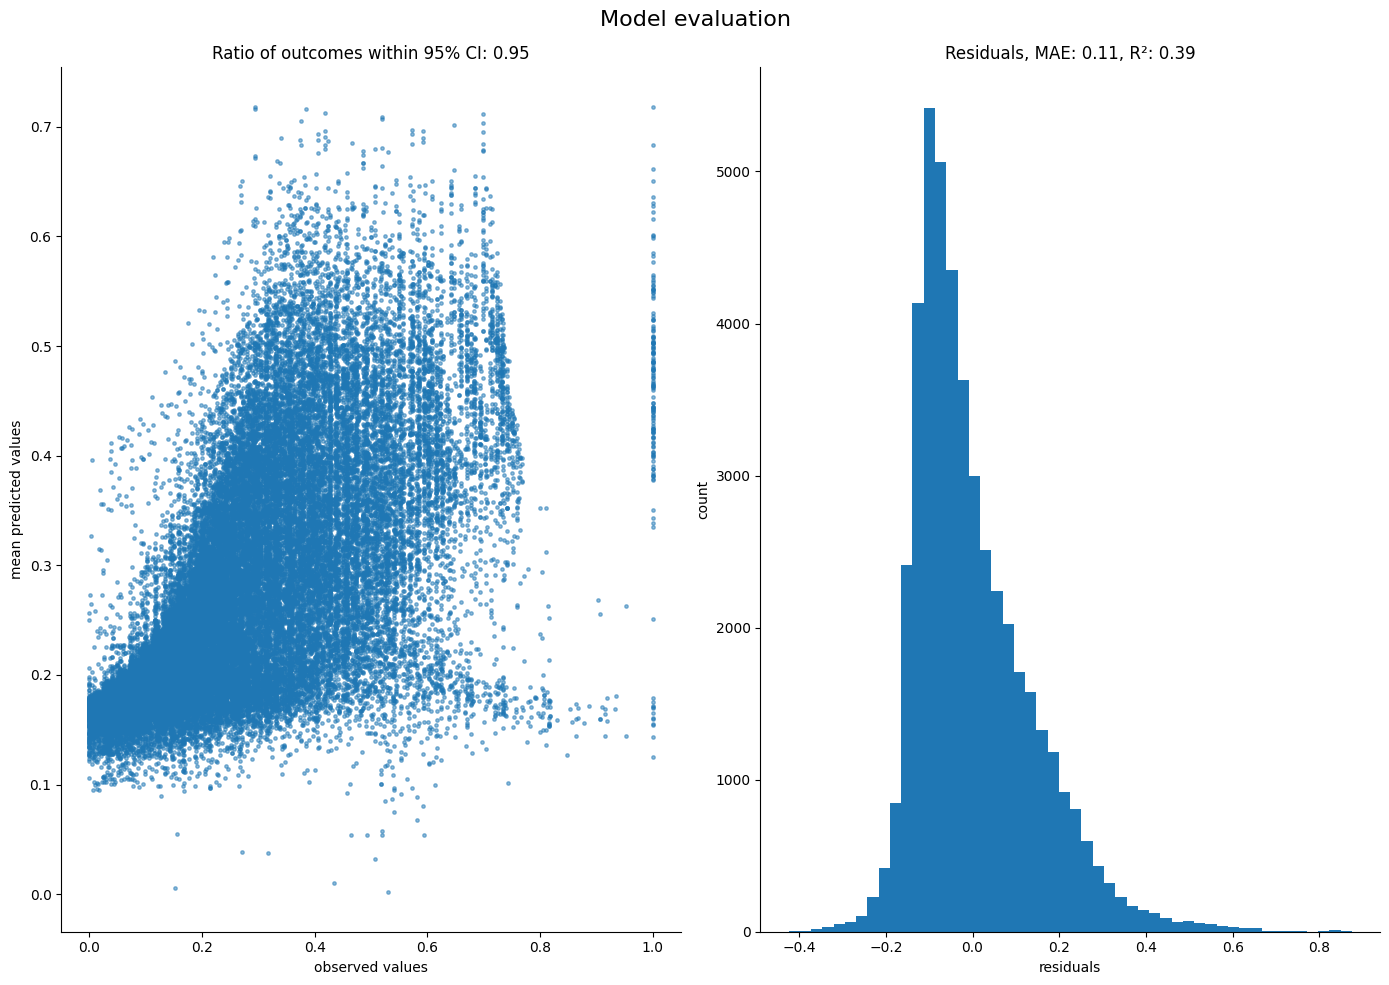

In [7]:
selected_sites = [
    key
    for key in results_follower["samples"].keys()
    if key.startswith("weight") and not key.endswith("sigma")
]
selected_samples = {key: results_follower["samples"][key] for key in selected_sites}

ft.plot_coefs(
    selected_samples, "Follower foragers", nbins=120, ann_start_y=160, ann_break_y=50
)

# save the samples for future use
if not os.path.exists("sim_data/follower_foragers_samples.dill"):
    with open(os.path.join("sim_data", "follower_foragers_samples.dill"), "wb") as f:
        dill.dump(selected_samples, f)

ft.evaluate_performance(
    model=model_sigmavar_follower,
    guide=results_follower["guide"],
    predictors=predictor_tensors_follower,
    outcome=outcome_tensor_follower,
    num_samples=1000,
)

As expected, both `access` and `proximity` are now significant in explaining the agent movements, while `food` has no effect.